In [19]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import string
import nltk
import matplotlib.pyplot as plt
import re
import numpy as np

from wordcloud import WordCloud
from os import path
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

origdata = pd.read_csv('Reviews.csv',
                       usecols=['Score', 'Summary', 'Text'], nrows=50000)#,skiprows=range(30000,50000))
# print(origdata.head(3))

In [20]:
def binary(x):
    if x > 3:
        return 'positive'
    return 'negative'


Score = origdata['Score']
Score = Score.map(binary)
Text = origdata['Text']
Summary = origdata['Summary']
Xtrain, Xtest, ytrain, ytest = train_test_split(
    Text, Score, test_size=0.2, random_state=42)

rmvpunc = str.maketrans(string.punctuation, "                                ")
rmvnum = re.compile('[^a-zA-Z]+')
stemmer = SnowballStemmer("english")

def cleandata(eachText):
    eachText = rmvnum.sub(' ', eachText).strip()
    eachText = eachText.lower()
    eachText = eachText.translate(rmvpunc)
    #tokens = nltk.word_tokenize(eachText)
    #stemmed = []
    #for eachitem in tokens:
    #    stemmed.append(stemmer.stem(eachitem))
    #eachText = ' '.join(stemmed)
    return eachText


corpus = []
for eachi in Xtrain:
    corpus.append(cleandata(eachi))

countvect = CountVectorizer(min_df = 2, ngram_range = (1, 4))
Xtraincounts = countvect.fit_transform(corpus)

tfidf = TfidfTransformer()
Xtraintfidf = tfidf.fit_transform(Xtraincounts)

testset = []
for eachi in Xtest:
    testset.append(cleandata(eachi))

Xnewcounts = countvect.transform(testset)
Xtesttfidf = tfidf.transform(Xnewcounts)

df = pd.DataFrame({ 'Before': Xtrain,'After': corpus})
print(df.head(20))

prediction = dict()

                                                  After  \
9254  i like columbian coffee and this is above aver...   
1561  different flavors for different people not eve...   
1670  i tried these in colorado and came home to fin...   
6087  i just love this chili it is beefier chunkier ...   
6669  there is gum acacia in the list of ingredients...   
5933  organic and loaded with calories fat and prote...   
8829  i used to work at that well known coffee shop ...   
7945  i just received my tea thanks for getting it o...   
3508  this hot chocolate is very good and flavorful ...   
2002  my family absolutely loves this pancake and wa...   
5866  la tourangelle makes some really good oils i l...   
168   besides being smaller than runts they look the...   
2588  my family and i love almond crunch they re jus...   
5905  these are excellent snack crackers but you nee...   
9529  i love this green tea it is a good price for m...   
6384  of course nobody can ever figure out what cats... 

In [21]:
model = MultinomialNB(alpha=0.01).fit(Xtraintfidf, ytrain)
prediction['Multinomial'] = model.predict(Xtesttfidf)


model = BernoulliNB(alpha=0.01).fit(Xtraintfidf, ytrain)
prediction['Bernoulli'] = model.predict(Xtesttfidf)


logisticreg = linear_model.LogisticRegression(C=1e9,verbose=1)
logreg_result = logisticreg.fit(Xtraintfidf, ytrain)
prediction['Logistic'] = logisticreg.predict(Xtesttfidf)

[LibLinear]

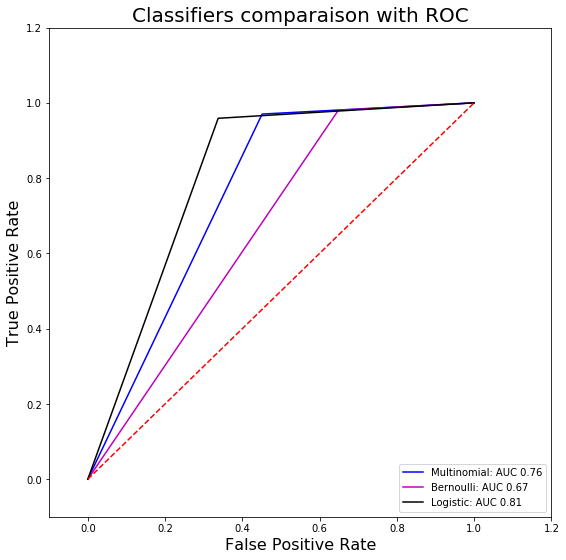

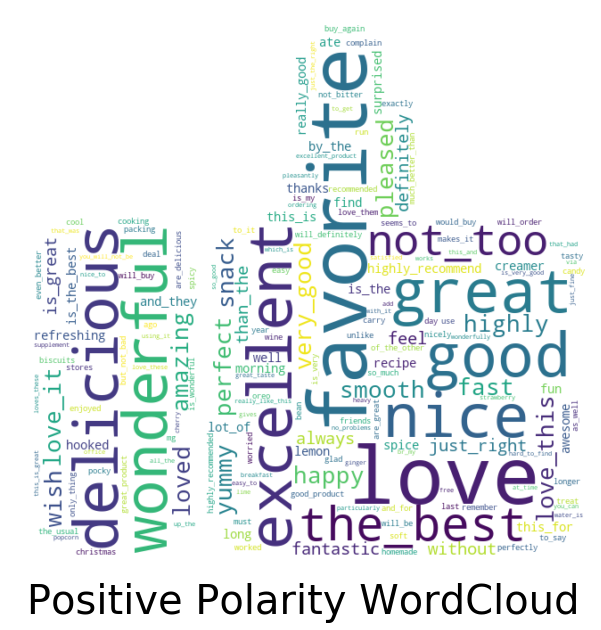

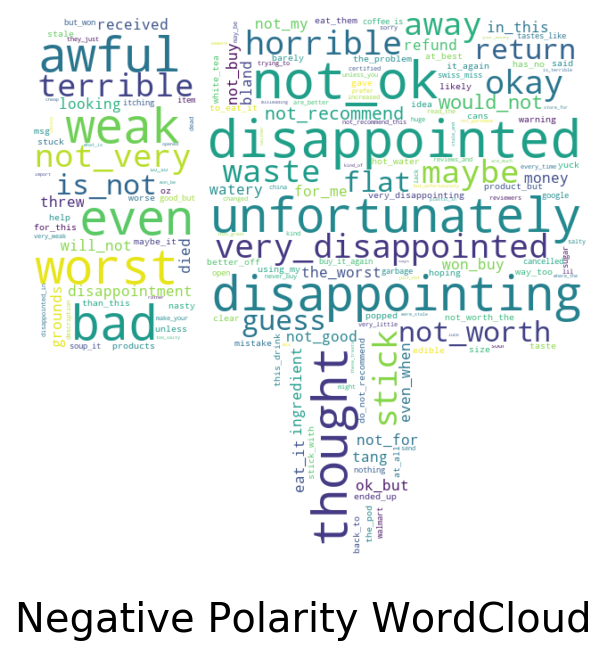

In [36]:
def binarynum(x):
    if x == 'positive':
        return 1
    return 0


vfunc = np.vectorize(binarynum)
fig = plt.figure(figsize=[9,9])
j = 0
colors = ['b', 'm', 'k', 'y', 'g']
for model, predicted in prediction.items():
    fprate, tprate, thresholds = roc_curve(
        ytest.map(binarynum), vfunc(predicted))
    roc_auc = auc(fprate, tprate)
    plt.plot(fprate, tprate,
             colors[j], label='%s: AUC %0.2f' % (model, roc_auc))
    j += 1


plt.legend(loc='lower right')
plt.title('Classifiers comparaison with ROC', fontsize=20)
plt.ylim([-0.1, 1.2])
plt.xlim([-0.1, 1.2])
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)

#plt.show()

words = countvect.get_feature_names()
polarities = pd.DataFrame(
    data=list(zip(words, logreg_result.coef_[0])),
    columns=['feature', 'coef'])

polarities = polarities.sort_values(by='coef')

positive_words = ''

negative_words = ''

polarities_new = polarities.reset_index(drop=True)

for x in range(0, 200):
    if polarities_new['feature'][x] not in stopwords.words('english'):
        if polarities_new['feature'][x] not in negative_words:
            negative_words = negative_words + polarities_new['feature'][x].replace(" ", "_") + ' '

for x in range(len(polarities)-1, len(polarities)-199, -1):
    if polarities_new['feature'][x] not in stopwords.words('english'):
        if polarities_new['feature'][x] not in positive_words:
            positive_words = positive_words + polarities_new['feature'][x].replace(" ", "_") + ' '

good_mask = np.array(Image.open('ttup.jpg'))
bad_mask = np.array(Image.open('ttdown.jpg'))

            
wc = WordCloud(background_color="white", mask=good_mask, max_font_size=90)
# generate word cloud
wc.generate(positive_words)
fig = plt.figure(figsize=[10,10])            
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.figure()
fig.suptitle('Positive Polarity WordCloud', fontsize=40)
fig.subplots_adjust(top=2.65)
plt.show()
print('\n\n\n')
wc = WordCloud(background_color="white", mask=bad_mask, max_font_size=90)
# generate word cloud

wc.generate(negative_words.replace("ok ", "not_ok "))
fig = plt.figure(figsize=[10,10])  
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
fig.suptitle('Negative Polarity WordCloud', fontsize=40)
fig.subplots_adjust(top=2.7)
#plt.figure()
plt.show()


In [35]:
def checkprob(model, s):
    scounts = countvect.transform([s])
    stfidf = tfidf.transform(scounts)
    result = model.predict(stfidf)[0]
    prob = model.predict_proba(stfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

def getFeaturePolarity(feat):
    foodlist = list()
    sum = 0
    posReviews = 0
    negReviews = 0
    for i in range(len(polarities['feature'])):
        if feat in polarities['feature'][i]:
            foodlist.append(polarities['feature'][i])
            coeff = polarities['coef'][i]
            if coeff<0:
                negReviews = negReviews + 1
            else:
                posReviews = posReviews + 1
            sum = sum+polarities['coef'][i]
    print("Feature Polarity: %s, Negative Reviews: %s , Positive Reviews: %s"%(sum,negReviews,posReviews))


while(1):
    print("\n\nChoose one of the following")
    print("0-Exit")
    print("1-Predict review sentiment")
    print("2-Check feature polarity")
    valRead = input()
    if valRead=="0":
        print("exiting...")
        break
    elif valRead=="1":
        print("Enter review")
        reviewRead = input()
        print("calculating...")
        checkprob(logisticreg,reviewRead)
    elif valRead=="2":
        print("Enter Feature")
        featRead = input()
        print("calculating...")
        getFeaturePolarity(featRead)
    else:
        print("wrong input")



Choose one of the following
0-Exit
1-Predict review sentiment
2-Check feature polarity
1
Enter review
food was great
calculating...
Sample estimated as POSITIVE: negative prob 0.000000, positive prob 1.000000


Choose one of the following
0-Exit
1-Predict review sentiment
2-Check feature polarity
1
Enter review
the smell was awful
calculating...
Sample estimated as NEGATIVE: negative prob 0.995194, positive prob 0.004806


Choose one of the following
0-Exit
1-Predict review sentiment
2-Check feature polarity
2
Enter Feature
service
calculating...
Feature Polarity: 24.623113012572148, Negative Reviews: 20 , Positive Reviews: 40


Choose one of the following
0-Exit
1-Predict review sentiment
2-Check feature polarity
2
Enter Feature
time
calculating...
Feature Polarity: 12.462643179692826, Negative Reviews: 438 , Positive Reviews: 786


Choose one of the following
0-Exit
1-Predict review sentiment
2-Check feature polarity
0
exiting...


  (0, 74073)	0.02208760066311759
  (0, 30684)	0.14536091273546903
  (0, 29129)	0.05647455954579366
  (0, 4639)	0.012456117791796244
  (0, 131617)	0.029392925308242935
  (0, 63708)	0.045678086683025115
  (0, 378)	0.06450862285588346
  (0, 13548)	0.12007808571630335
  (0, 150693)	0.059444632122338366
  (0, 52033)	0.04693418920723254
  (0, 34185)	0.04561664298610716
  (0, 30625)	0.054883928609845846
  (0, 85127)	0.03745248221866622
  (0, 110897)	0.04952979164223865
  (0, 121580)	0.036142150955255026
  (0, 117737)	0.050006786981890664
  (0, 18857)	0.14205876823603422
  (0, 119570)	0.028388913351569147
  (0, 22969)	0.01876421910553153
  (0, 86015)	0.020003846074555208
  (0, 141136)	0.06625449449800684
  (0, 93776)	0.025717612164180108
  (0, 18025)	0.04485484258997875
  (0, 82581)	0.017798631075266625
  (0, 115378)	0.04019650408961424
  :	:
  (7999, 51449)	0.0744082720805482
  (7999, 32092)	0.0780895274744212
  (7999, 47553)	0.07606358643669256
  (7999, 91640)	0.07179637981224687
  (7999, 11

In [40]:
print(ytrain.reset_index(drop=True))

0       positive
1       positive
2       positive
3       positive
4       positive
5       positive
6       positive
7       positive
8       positive
9       positive
10      positive
11      negative
12      positive
13      positive
14      positive
15      positive
16      positive
17      positive
18      positive
19      positive
20      negative
21      negative
22      negative
23      positive
24      negative
25      positive
26      positive
27      positive
28      positive
29      positive
          ...   
7970    positive
7971    negative
7972    positive
7973    positive
7974    positive
7975    negative
7976    positive
7977    positive
7978    negative
7979    positive
7980    positive
7981    positive
7982    positive
7983    positive
7984    negative
7985    positive
7986    positive
7987    negative
7988    negative
7989    positive
7990    positive
7991    negative
7992    positive
7993    positive
7994    positive
7995    positive
7996    negative
7997    positi